In [28]:
!!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install easyocr

In [3]:

import pytesseract
from pytesseract import Output
import cv2
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

from imutils.perspective import four_point_transform



## Resize the image and set aspect ratio

In [4]:
url = "img_vernier/626519.jpg"
url ="https://raw.githubusercontent.com/Tuchsanai/Meter_Reader/main/Digital01/img_vernier/626519.jpg"
img = io.imread(url)




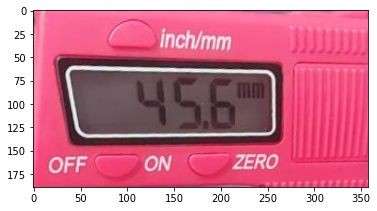

In [5]:
def find_Plastic_module_withColor_MAPPING(img):

    # define range of blue color in HSV
    low_red = np.array([168, 100, 220], dtype=np.uint8)
    high_red = np.array([175, 240,255], dtype=np.uint8)

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    # Threshold the HSV image to get only blue colors
    maskb = cv2.inRange(hsv, low_red, high_red)


    contour,hierarchy = cv2.findContours(maskb,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour           = sorted(contour, key=cv2.contourArea, reverse=True)

    for c in  contour:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        if len(approx) == 4:
             four_points = np.squeeze(approx)
             imgx        = four_point_transform(img,four_points)
             return imgx
         
    return None




img2 = find_Plastic_module_withColor_MAPPING(img)

plt.imshow(img2)

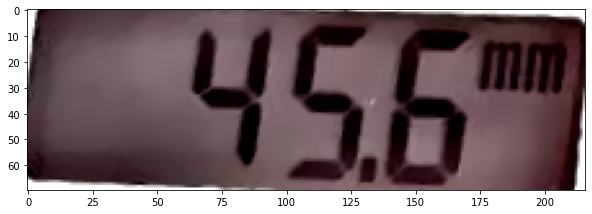

In [33]:
def FindLCD(img ,threshold = 180):
    # Grayscale and Canny Edges extracted
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    ret,th = cv2.threshold(blur,threshold,255,0)

    #plt.imshow(th)

    contour,hierarchy = cv2.findContours(th,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour          = sorted(contour, key=cv2.contourArea, reverse=True)
    for contour in contour:
        peri = cv2.arcLength(contour,True)
        approx = cv2.approxPolyDP(contour,0.08*peri, True)
        
        if len(approx) == 4:
            four_points = np.squeeze(approx)
            imgx       = four_point_transform(img,four_points)
            imgx       = cv2.detailEnhance(imgx,sigma_s =25 , sigma_r = 0.3)
            imgx = cv2.bilateralFilter(imgx, 9, 27, 27)
            return imgx

    return None


lcd_img=FindLCD(img2)



plt.figure(figsize=(10,10))
plt.imshow(lcd_img)

In [4]:
import cv2
import easyocr
reader = easyocr.Reader(['en'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [5]:
bounds = reader.readtext( lcd_img )
bounds

NameError: name 'lcd_img' is not defined

In [34]:
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

In [35]:

magic_image = apply_brightness_contrast(lcd_img,120,0)
magic_image_c1 = apply_brightness_contrast(lcd_img,0,40)
magic_image_c2 = apply_brightness_contrast(lcd_img,120,40)

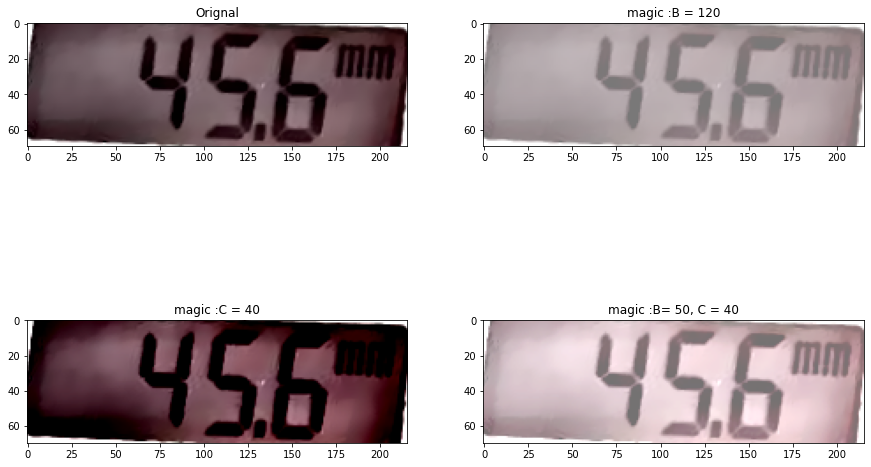

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(lcd_img)
plt.title('Orignal')


plt.subplot(2,2,2)
plt.imshow(magic_image)
plt.title('magic :B = 120')

plt.subplot(2,2,3)
plt.imshow(magic_image_c1)
plt.title('magic :C = 40')


plt.subplot(2,2,4)
plt.imshow(magic_image_c2)
plt.title('magic :B= 50, C = 40')

plt.show()

In [10]:
d = pytesseract.image_to_string( img )
d

''

In [22]:
print(d)

In [1]:
import cv2
import easyocr
reader = easyocr.Reader(['en'], gpu=False)

C:\Users\SkywalkerPC\anaconda3\envs\torch\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\SkywalkerPC\anaconda3\envs\torch\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Using CPU. Note: This module is much faster with a GPU.


In [3]:
bounds = reader.readtext( lcd_img )
bounds

NameError: name 'lcd_img' is not defined

In [45]:
bounds[0][1]

'4561'